In [1]:
! pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50, MobileNetV2
from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from keras.models import load_model, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fid = drive.ListFile({'q':"title='binary_ct.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('binary_ct.zip')

In [8]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [9]:
!unzip binary_ct.zip

Streaming output truncated to the last 5000 lines.
  inflating: binary_ct/train/covid/pCT1006.jpg  
  inflating: binary_ct/train/covid/pCT1009.jpg  
  inflating: binary_ct/train/covid/pCT1012.jpg  
  inflating: binary_ct/train/covid/pCT1013.jpg  
  inflating: binary_ct/train/covid/pCT1015.jpg  
  inflating: binary_ct/train/covid/pCT1018.jpg  
  inflating: binary_ct/train/covid/pCT1019.jpg  
  inflating: binary_ct/train/covid/pCT1022.jpg  
  inflating: binary_ct/train/covid/pCT1024.jpg  
  inflating: binary_ct/train/covid/pCT1025.jpg  
  inflating: binary_ct/train/covid/pCT1030.jpg  
  inflating: binary_ct/train/covid/pCT1044.jpg  
  inflating: binary_ct/train/covid/pCT1046.jpg  
  inflating: binary_ct/train/covid/pCT1048.jpg  
  inflating: binary_ct/train/covid/pCT1050.jpg  
  inflating: binary_ct/train/covid/pCT1051.jpg  
  inflating: binary_ct/train/covid/pCT1053.jpg  
  inflating: binary_ct/train/covid/pCT1056.jpg  
  inflating: binary_ct/train/covid/pCT1059.jpg  
  inflating: binar

In [10]:
train_path = "/content/binary_ct/train"
test_path = "/content/binary_ct/test"

In [11]:
PATH = '/content/binary_ct'
os.listdir(PATH)
train_dir = os.path.join(PATH,
                         'train')
test_dir = os.path.join(PATH,
                        'test')
train_normal_dir = os.path.join(train_dir,
                                'normal')
train_covid19_dir = os.path.join(train_dir,
                               'covid-19')

test_normal_dir = os.path.join(test_dir,
                               'normal')
test_covid19_dir = os.path.join(test_dir,
                              'covid-19')
len(os.listdir(train_normal_dir))


3000

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=20,
 featurewise_center = True,
 featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 zca_whitening = False,
 channel_shift_range = 20,
 horizontal_flip = False ,
 vertical_flip = False ,
 validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (224, 224),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


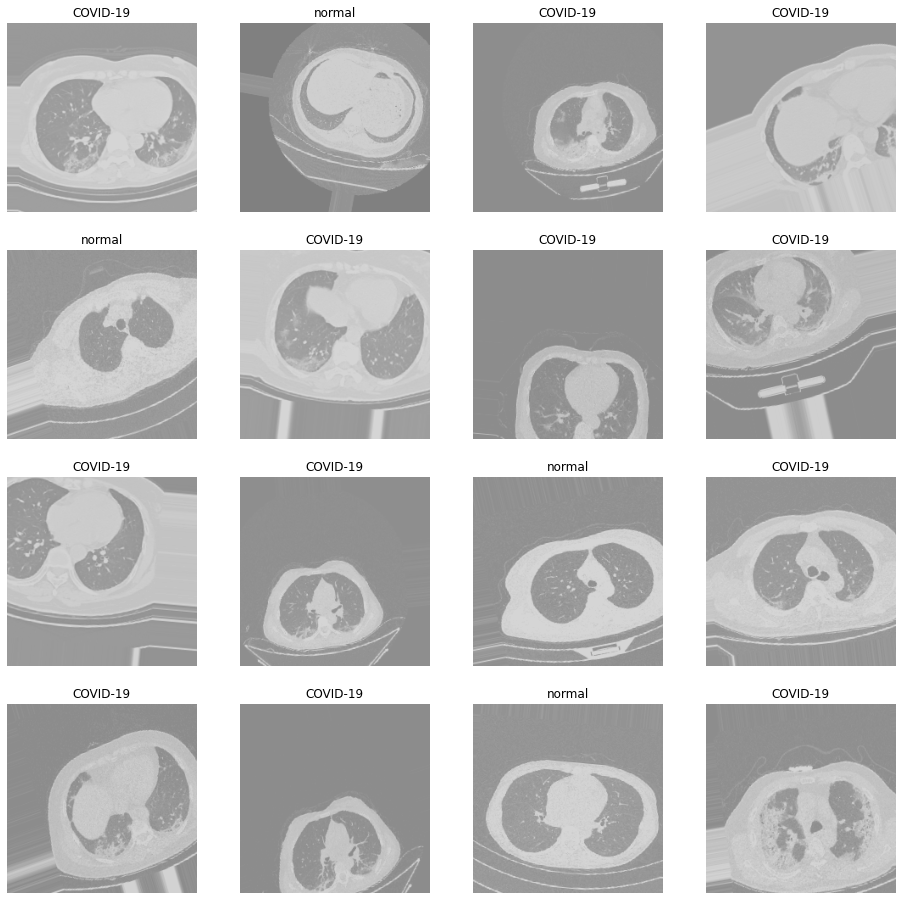

In [15]:
all_labels = ['COVID-19','normal']
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [19]:
import tensorflow
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import load_model, Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.models import Model
from tensorflow.keras.models import Model, load_model
from __future__ import print_function, division
from builtins import range, input
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from glob import glob
import pandas as pd

In [21]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [24]:
epochs= 100

BS = 16

In [25]:
#history = model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=BS),steps_per_epoch=len(X_train) // BS,validation_data=(X_test, Y_test),validation_steps=len(X_test) // BS,epochs=epochs)
model.fit_generator(train_generator,
                    steps_per_epoch = 318//BS,
                    epochs = epochs,
                    validation_data = test_generator,
                    validation_steps = 48//BS)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
19/19 [==============================] - 12s 286ms/step - loss: 0.7887 - accuracy: 0.4972 - val_loss: 0.7052 - val_accuracy: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 5s 274ms/step - loss: 0.6911 - accuracy: 0.5936 - val_loss: 0.6828 - val_accuracy: 1.0000
Epoch 3/100
19/19 [==============================] - 5s 278ms/step - loss: 0.6942 - accuracy: 0.5299 - val_loss: 0.6822 - val_accuracy: 1.0000
Epoch 4/100
19/19 [==============================] - 5s 271ms/step - loss: 0.6926 - accuracy: 0.5197 - val_loss: 0.6904 - val_accuracy: 1.0000
Epoch 5/100
19/19 [==============================] - 5s 281ms/step - loss: 0.6914 - accuracy: 0.5408 - val_loss: 0.6595 - val_accuracy: 1.0000
Epoch 6/100
19/19 [==============================] - 5s 271ms/step - loss: 0.6839 - accuracy: 0.5284 - val_loss: 0.6926 - val_accuracy: 0.3333
Epoch 7/100
19/19 [==============================] - 5s 280ms/step - loss: 0.6597 - accuracy: 0.5990 - val_loss: 0.8331 - val_accuracy: 0

In [26]:
x = model.evaluate_generator(test_generator,
 steps = np.ceil(len(test_generator) // BS),
 use_multiprocessing = False,
 verbose = 1,
 workers=1
 )

15/62 [======>.......................] - ETA: 0s - loss: 10.3115 - accuracy: 0.6000

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


62/62 [==============================] - 0s 7ms/step - loss: 3.7536 - accuracy: 0.7097


In [27]:
from keras.callbacks import History 
history = History()

 1/30 [>.............................] - ETA: 3s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


30/30 [==============================] - 0s 7ms/step
Predictions finished
prob:[1.4771838e-21 1.0000000e+00]
covid/pCT1.jpg


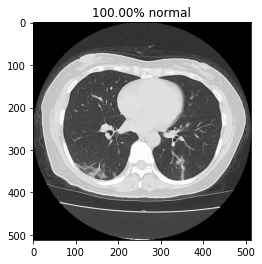

prob:[9.127118e-23 1.000000e+00]
covid/pCT10.jpg


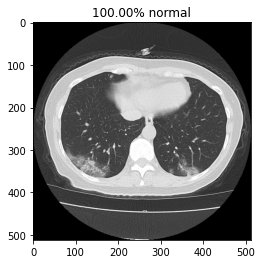

prob:[0.62047017 0.37952986]
covid/pCT100.jpg


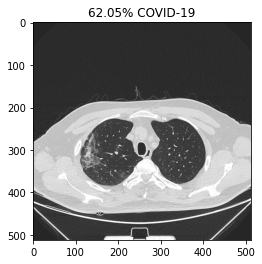

prob:[0.4559899  0.54401004]
covid/pCT101.jpg


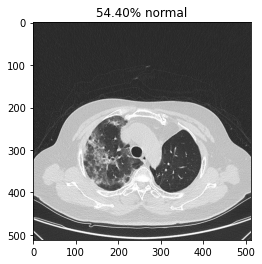

prob:[0.99832684 0.00167321]
covid/pCT102.jpg


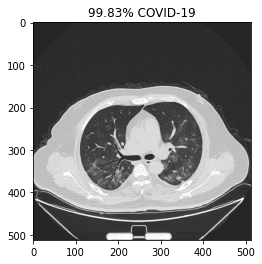

prob:[0.99479806 0.00520186]
covid/pCT103.jpg


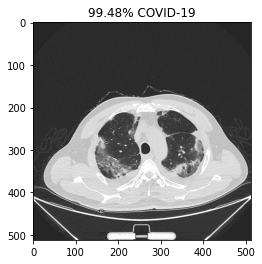

prob:[0.6765743  0.32342574]
covid/pCT104.jpg


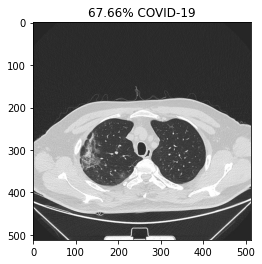

prob:[0.33306494 0.666935  ]
covid/pCT105.jpg


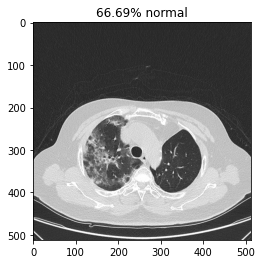

prob:[0.99849105 0.00150899]
covid/pCT106.jpg


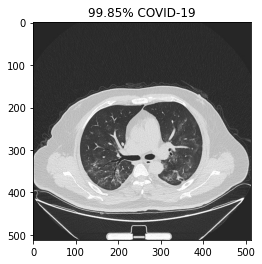

prob:[0.9957765  0.00422351]
covid/pCT107.jpg


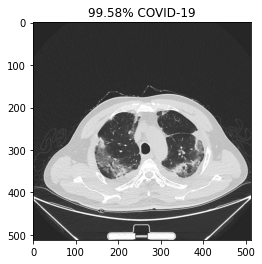

prob:[0.68180835 0.31819162]
covid/pCT108.jpg


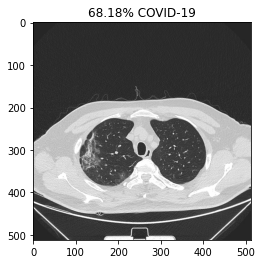

prob:[0.24770878 0.7522912 ]
covid/pCT109.jpg


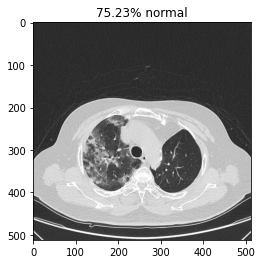

prob:[4.7104052e-23 1.0000000e+00]
covid/pCT11.jpg


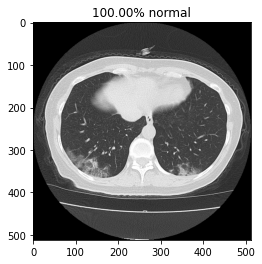

prob:[0.99821717 0.00178282]
covid/pCT110.jpg


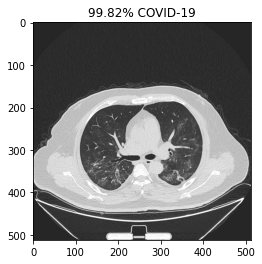

prob:[0.99581593 0.00418405]
covid/pCT111.jpg


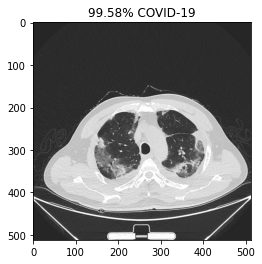

prob:[0.6182677  0.38173226]
covid/pCT112.jpg


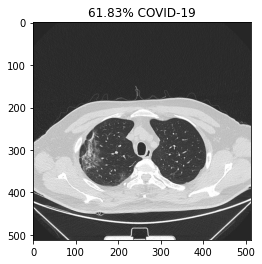

prob:[0.20632239 0.7936776 ]
covid/pCT113.jpg


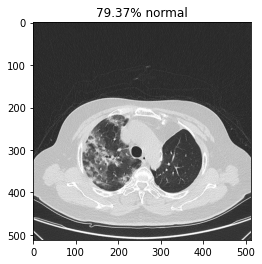

prob:[0.99783    0.00216996]
covid/pCT114.jpg


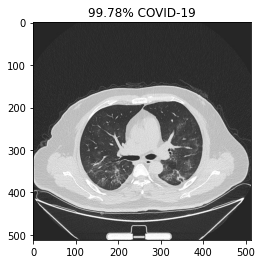

prob:[0.9954684  0.00453156]
covid/pCT115.jpg


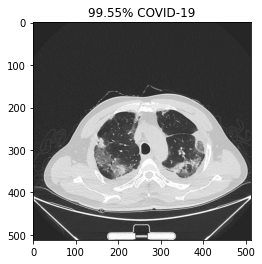

prob:[0.6672785 0.3327215]
covid/pCT116.jpg


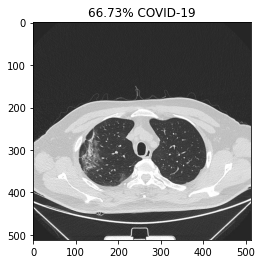

prob:[0.26005694 0.7399431 ]
covid/pCT117.jpg


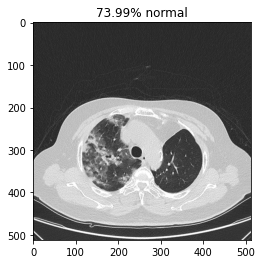

prob:[0.99765563 0.00234432]
covid/pCT118.jpg


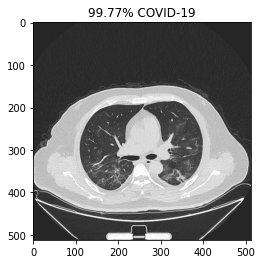

prob:[0.99632734 0.00367262]
covid/pCT119.jpg


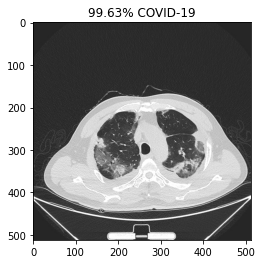

prob:[8.1477925e-24 1.0000000e+00]
covid/pCT12.jpg


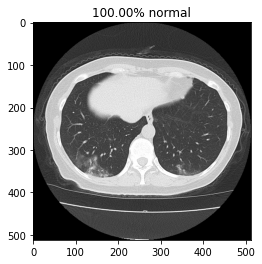

prob:[0.6448135  0.35518652]
covid/pCT120.jpg


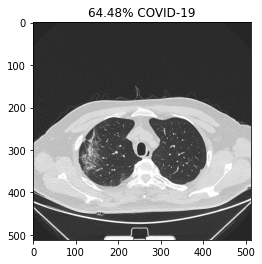

prob:[0.2718104 0.7281896]
covid/pCT121.jpg


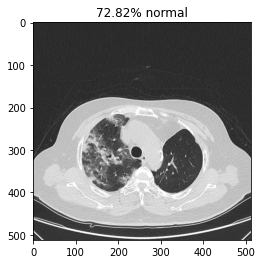

prob:[0.9977034  0.00229666]
covid/pCT122.jpg


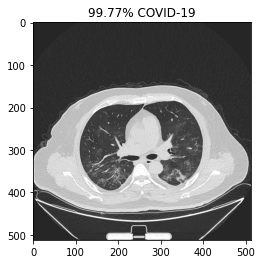

prob:[0.99717927 0.00282079]
covid/pCT123.jpg


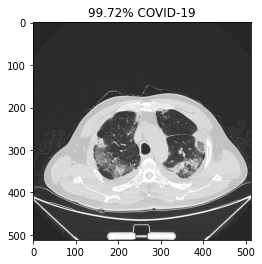

prob:[0.60977364 0.3902264 ]
covid/pCT124.jpg


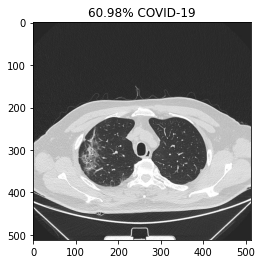

prob:[0.3265594  0.67344064]
covid/pCT125.jpg


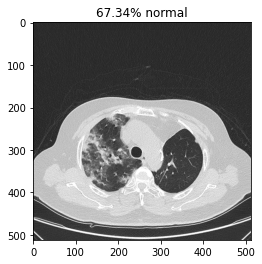

In [28]:
#eval_generator.reset() 
pred = model.predict_generator(test_generator,30,verbose=1)
print("Predictions finished")
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred):
 image_path = test_path + "/" +test_generator.filenames[index]
 image = mpimg.imread(image_path)
 #BGR TO RGB conversion using CV2
 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 pixels = np.array(image)
 plt.imshow(pixels)
 print("prob:{}".format(probability))
 print(test_generator.filenames[index])
 if probability[1] > 0.5:
     plt.title('%.2f' % (probability[1]*100) + '% normal')
 else:
     plt.title('%.2f' % ((1-probability[1])*100) + '% COVID-19')
 plt.show()

In [29]:
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Test loss: 3.753598213195801
Test accuracy: 0.7096773982048035


In [30]:
image_test = Image.open("/content/binary_ct/train/covid/pCT1002.jpg").convert('RGB')
image_test = image_test.resize((224,224))
data_test = np.asarray(image_test)
img = np.reshape(data_test,[1,224,224,3])

[[1.0, 0.0]]

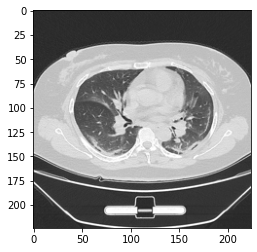

In [32]:
plt.imshow(image_test)
model.predict(img).tolist()

In [33]:
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
Y_pred = model.predict_generator(test_generator, np.ceil(len(test_generator) ))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [34]:
y_pred = np.argmax(Y_pred, axis=1)

In [35]:
print(confusion_matrix(test_generator.classes, y_pred))


[[432  68]
 [ 39 461]]


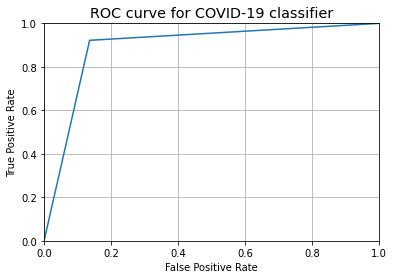

In [36]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_generator.classes, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for COVID-19 classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Text(0, 0.5, 'Frequency')

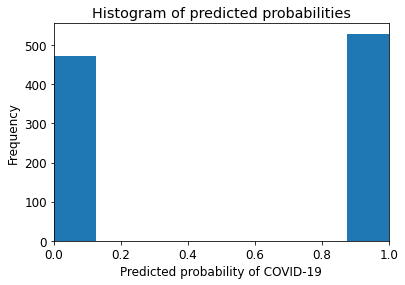

In [37]:
plt.hist(y_pred, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of COVID-19')
plt.ylabel('Frequency')

In [38]:
print('Classification Report')
target_names = ['COVID-19','other']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    COVID-19       0.92      0.86      0.89       500
       other       0.87      0.92      0.90       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [39]:
import itertools
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [40]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=y_pred)
cm_plot_labels= ['COVID-19','normal']

Confusion matrix, without normalization
[[432  68]
 [ 39 461]]


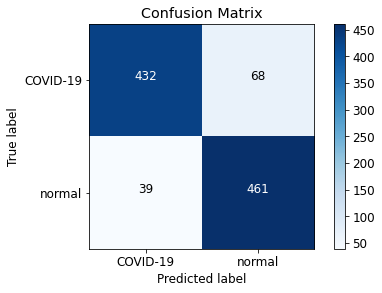

In [41]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')